### 1.Business Understanding

Our goal is to predict whether an earthquake event will generate a tsunami. The dataset suggests we have earthquake-related features and our task is to classify each event as either tsunami or no tsunami. This makes it a binary classification problem.
Decision supported by this model: enabling early warnings, prioritizing monitoring efforts, and flagging high-risk events for human review.

The main stakeholders include emergency managers, monitoring agencies, platform engineers, and data analysts who rely on timely and accurate alerts.
Primary objective: Maximize recall — we want to detect as many true tsunami events as possible (missing one could be catastrophic).
Secondary objective: Keep false alarms manageable, so teams don’t waste resources on false positives.

Accuracy isn’t enough here, if only 1% of earthquakes cause tsunamis, a model that always predicts “no tsunami” would be 99% accurate but completely useless.

So instead, we’ll judge performance using:Primary metric: Recall (Sensitivity) — how many real tsunami events the model correctly identifies.

Supporting metrics: Precision, F1-score, and PR-AUC (Precision-Recall AUC), which is more informative for imbalanced datasets than ROC-AUC.

Operational metric: False alarm rate at the chosen alert threshold.

### 2. Data Understanding

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./datasets/earthquake_data_tsunami.csv")

In [3]:
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [4]:
df.describe()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,870.108696,230.250639,1.325757,25.038990,75.883199,3.538100,52.609199,2012.280051,6.563939,0.388747
std,0.445514,3.169939,1.462724,322.465367,250.188177,2.218805,24.225067,137.277078,27.303429,117.898886,6.099439,3.507866,0.487778
min,6.500000,0.000000,1.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000,2001.000000,1.000000,0.000000
25%,6.600000,0.000000,5.000000,691.000000,0.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050,2007.000000,3.250000,0.000000
50%,6.800000,5.000000,6.000000,754.000000,140.000000,0.000000,20.000000,26.295000,-2.572500,109.426000,2013.000000,7.000000,0.000000
75%,7.100000,7.000000,7.000000,909.750000,445.000000,1.863000,30.000000,49.750000,24.654500,148.941000,2017.000000,10.000000,1.000000
max,9.100000,9.000000,9.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000,2022.000000,12.000000,1.000000


In [5]:
df.columns

Index(['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth',
       'latitude', 'longitude', 'Year', 'Month', 'tsunami'],
      dtype='object')

In [6]:
df.shape

(782, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.5 KB


In [8]:
df.isnull().sum()

magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
tsunami_counts = df['tsunami'].value_counts().sort_index()
print(f"Class 0 (Non-Tsunami): {tsunami_counts[0]} events ({100 * tsunami_counts[0] / len(df):.2f}%)")
print(f"Class 1 (Tsunami): {tsunami_counts[1]} events ({100 * tsunami_counts[1] / len(df):.2f}%)")
print(f"Class Imbalance Ratio: {tsunami_counts[0] / tsunami_counts[1]:.3f}:1")

Class 0 (Non-Tsunami): 478 events (61.13%)
Class 1 (Tsunami): 304 events (38.87%)
Class Imbalance Ratio: 1.572:1


Some observations made are:

Shape: 782 rows × 13 columns. Zero duplicates.

Columns include: magnitude, cdi, mmi, sig, nst, dmin, gap, depth, latitude, longitude, Year, Month, tsunami.

Missingness: none in any column (nice and clean).

Coordinates: all lat/long values fall in valid ranges.

Candidate target: tsunami looks like a clean binary label (0/1). Class balance is moderately imbalanced (more 0s than 1s), but not extreme—expect to handle with class weights and careful thresholding.

Why these checks matter?

Basic sanity (shape, dtypes, missingness) tells us if we’re dealing with data quality problems before we write a single model line.

Target confirmation is critical. If the label is wrong or leaky, every result after this is meaningless.

Class balance guides metric choice and training strategy. With imbalance, accuracy is misleading—so we’ll rely on PR-AUC, recall, precision, and F1.

Latitude/longitude bounds catch obvious errors that wreck geospatial features.

In [11]:
tsunami_counts = df['tsunami'].value_counts().sort_index()
print(f"Class 0 (Non-Tsunami): {tsunami_counts[0]} events ({100 * tsunami_counts[0] / len(df):.2f}%)")
print(f"Class 1 (Tsunami): {tsunami_counts[1]} events ({100 * tsunami_counts[1] / len(df):.2f}%)")
print(f"Class Imbalance Ratio: {tsunami_counts[0] / tsunami_counts[1]:.3f}:1")

Class 0 (Non-Tsunami): 478 events (61.13%)
Class 1 (Tsunami): 304 events (38.87%)
Class Imbalance Ratio: 1.572:1


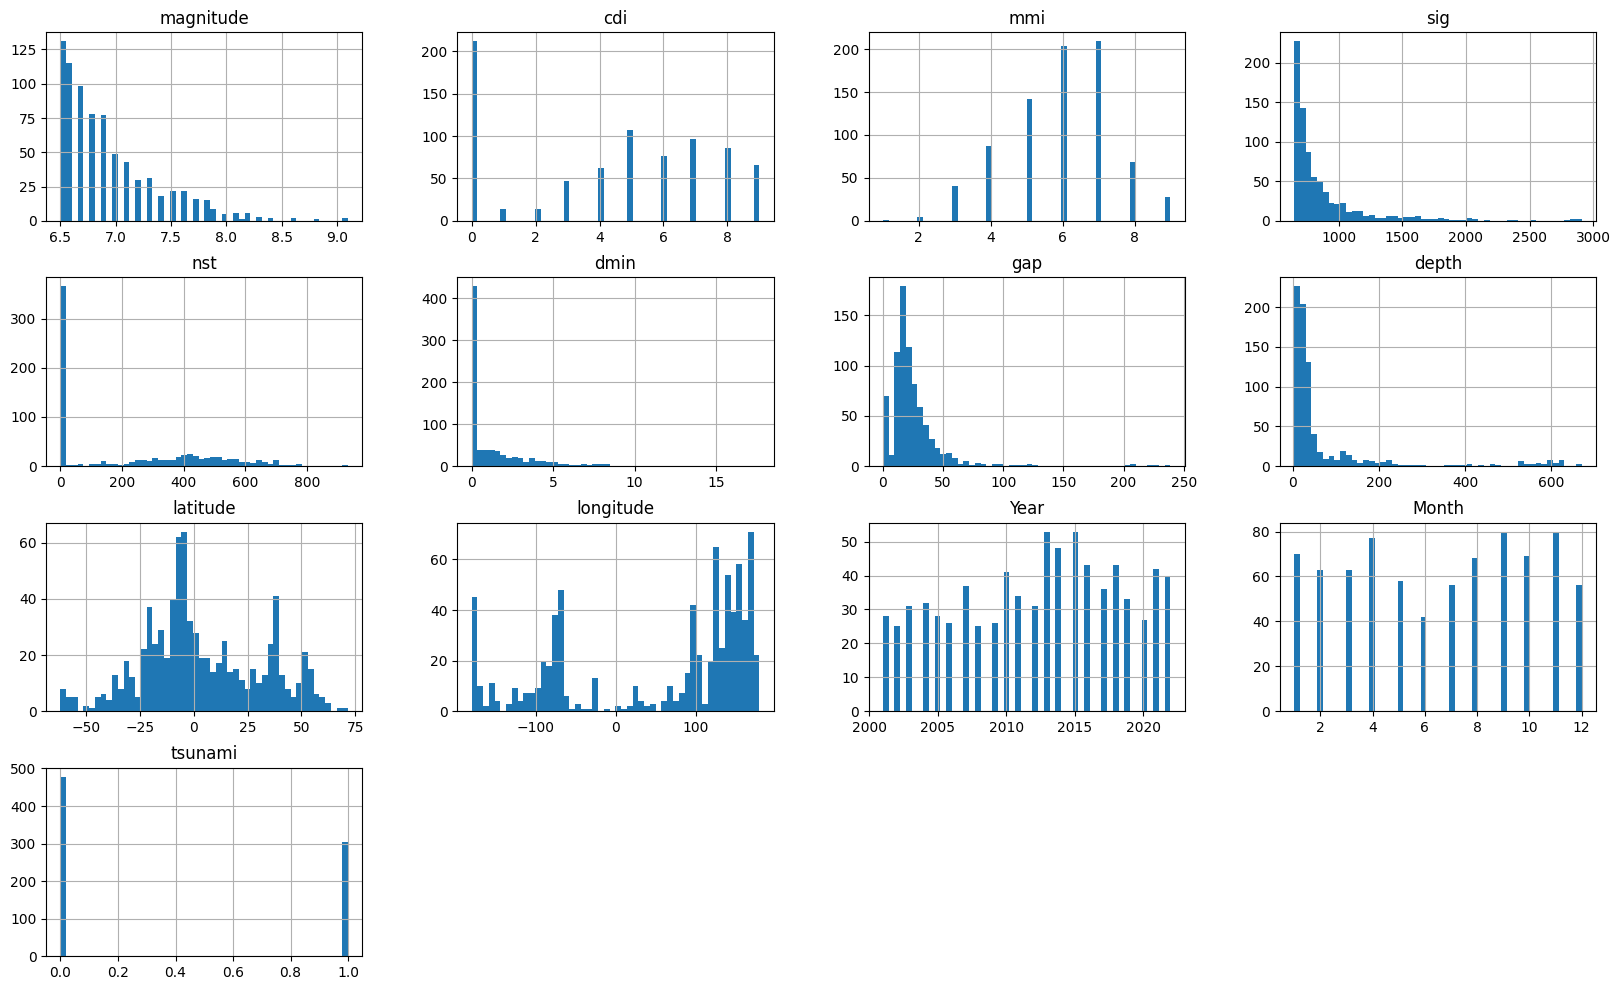

In [12]:
df.hist(figsize=(20,12), bins=50)
plt.show()


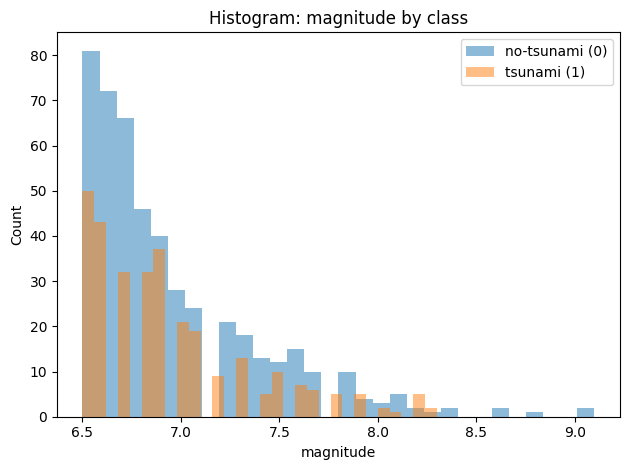

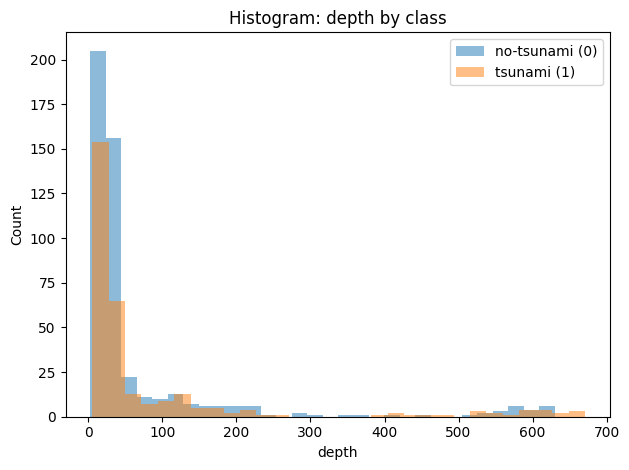

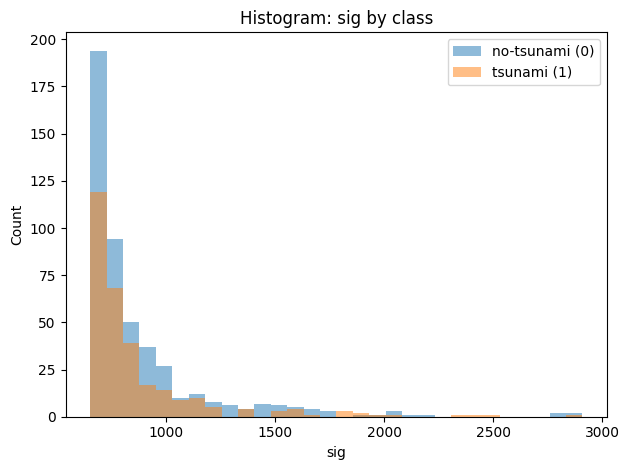

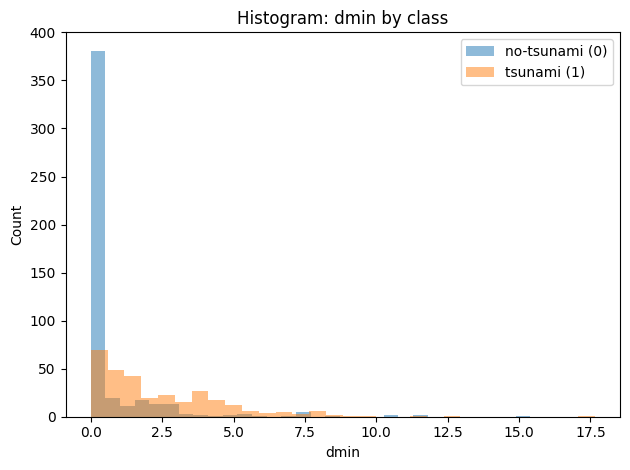

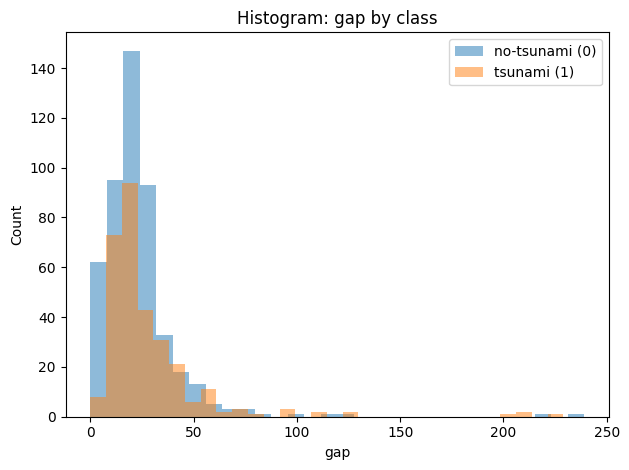

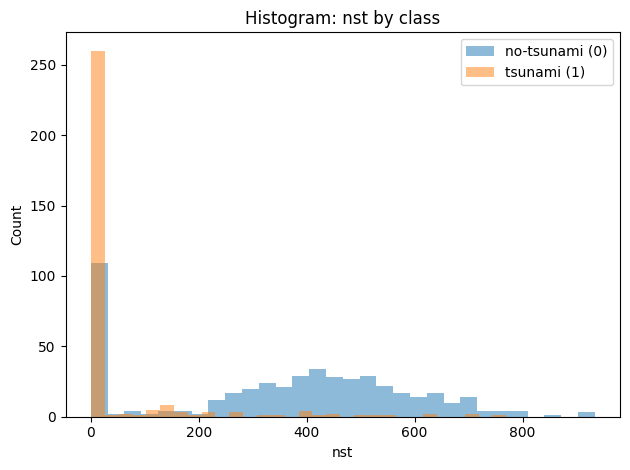

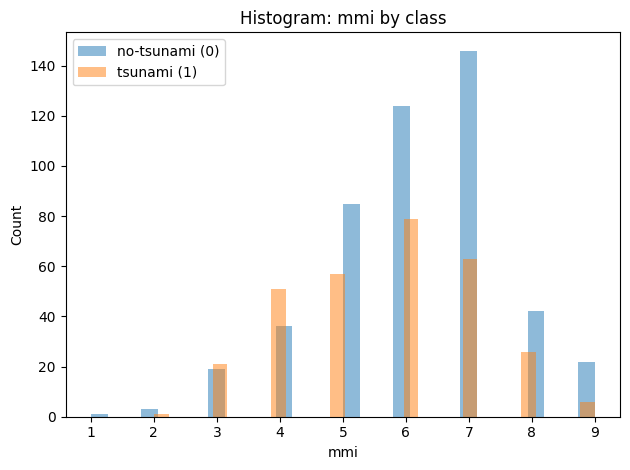

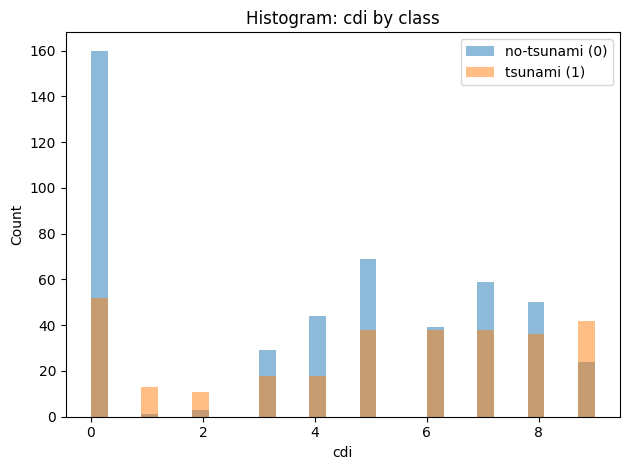

In [13]:
for feature in ["magnitude", "depth", "sig", "dmin", "gap", "nst", "mmi", "cdi"]:
    data0 = df[df['tsunami'] == 0][feature].dropna()
    data1 = df[df['tsunami'] == 1][feature].dropna()
    plt.figure()
    bins = 30
    plt.hist(data0, bins=bins, alpha=0.5, label="no-tsunami (0)")
    plt.hist(data1, bins=bins, alpha=0.5, label="tsunami (1)")
    plt.title(f"Histogram: {feature} by class")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

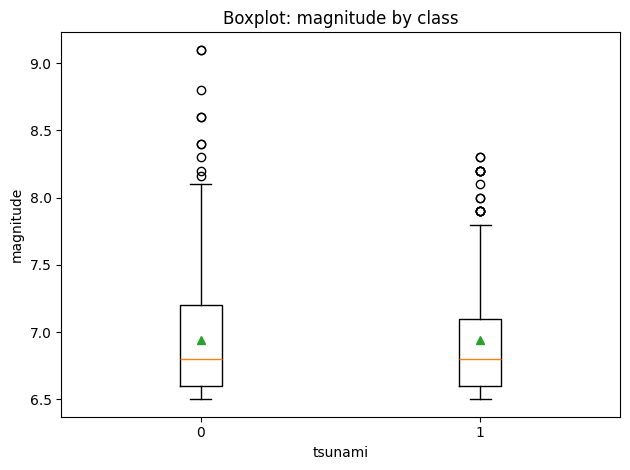

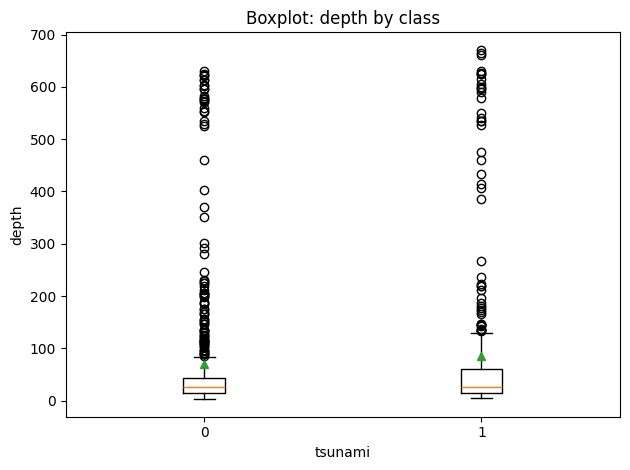

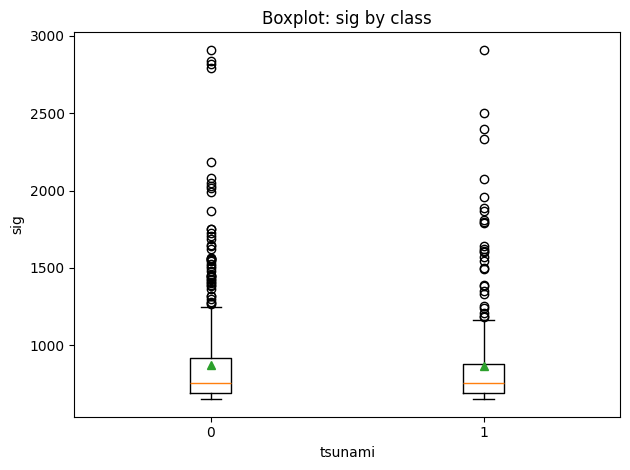

In [14]:
for feature in ["magnitude", "depth", "sig"]:
    group0 = df[df['tsunami'] == 0][feature].dropna().values
    group1 = df[df['tsunami'] == 1][feature].dropna().values
    plt.figure()
    plt.boxplot([group0, group1], tick_labels=["0", "1"], showmeans=True)
    plt.title(f"Boxplot: {feature} by class")
    plt.xlabel('tsunami')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()
    plt.close()

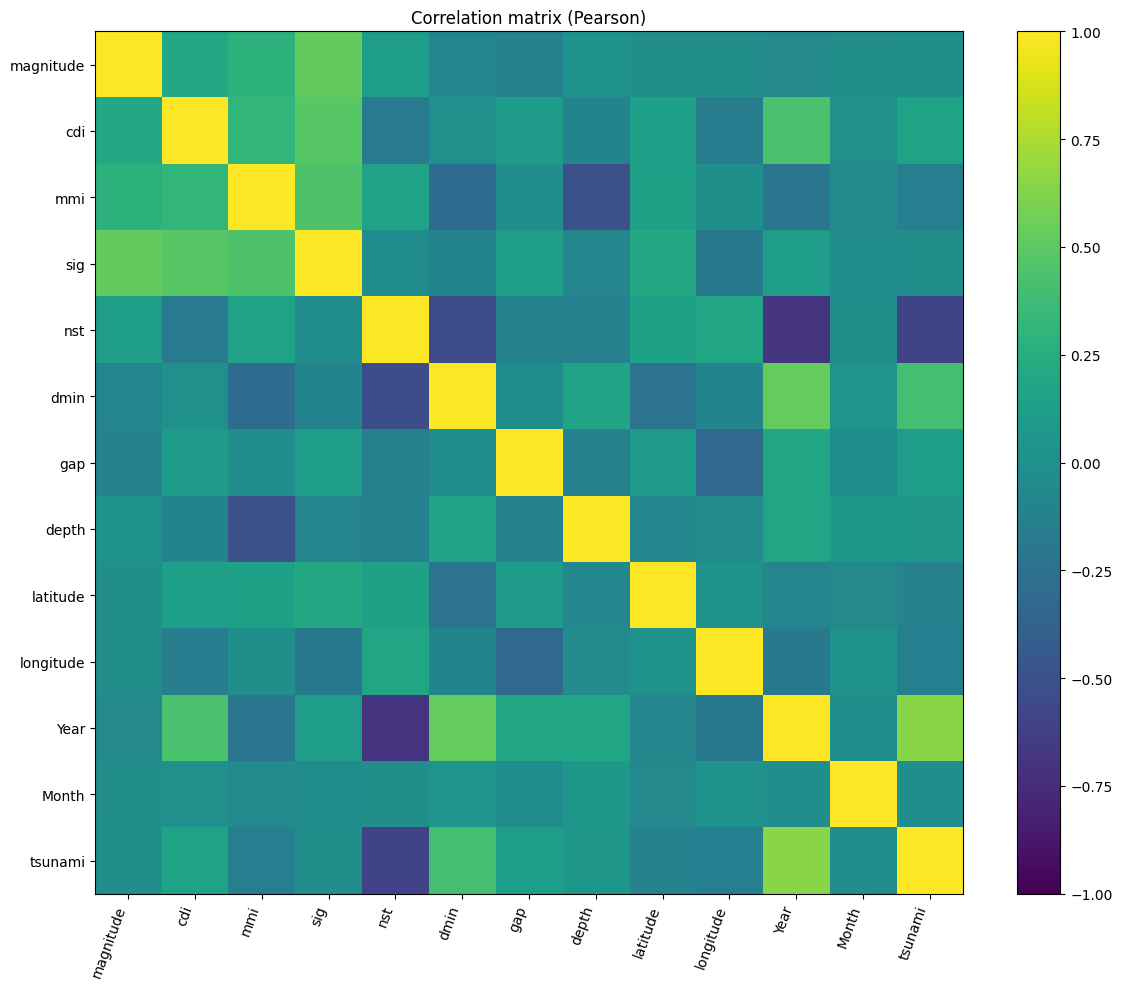

In [15]:
num = df.select_dtypes(include=[np.number]).drop(columns=[df['tsunami']], errors="ignore")
if num.shape[1] > 1:
    C = num.corr(method="pearson")
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(C.values, vmin=-1, vmax=1, aspect="auto")
    ax.set_xticks(range(len(C.columns))); ax.set_xticklabels(C.columns, rotation=70, ha="right")
    ax.set_yticks(range(len(C.index)));  ax.set_yticklabels(C.index)
    ax.set_title("Correlation matrix (Pearson)")
    plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()


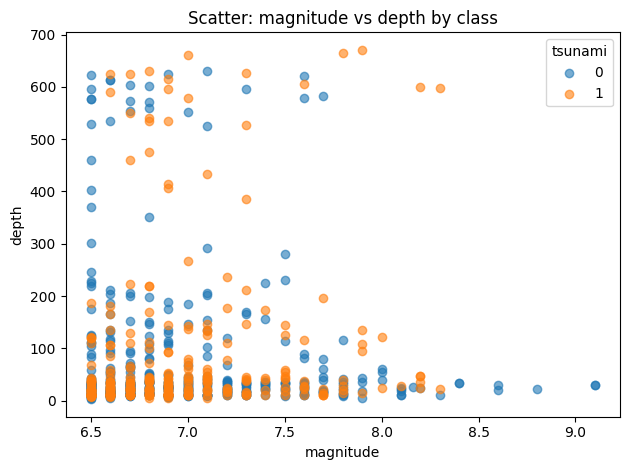

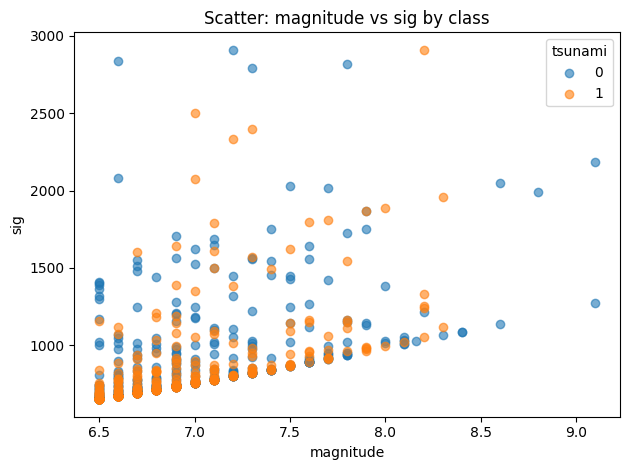

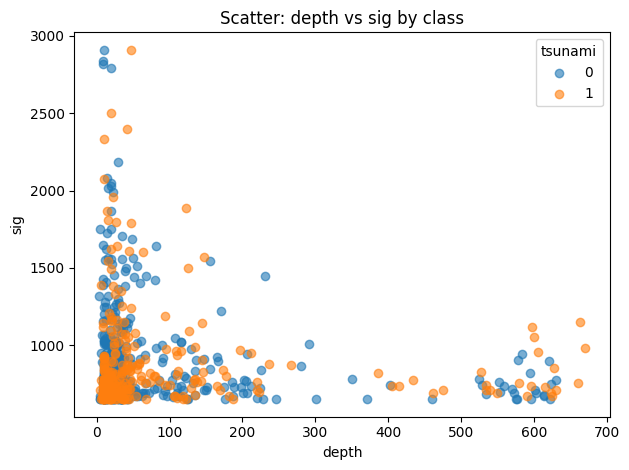

In [16]:
for (x, y) in [("magnitude", "depth"), ("magnitude", "sig"), ("depth", "sig")]:
    plt.figure()
    mask0 = df['tsunami'] == 0
    mask1 = df['tsunami'] == 1
    plt.scatter(df.loc[mask0, x], df.loc[mask0, y], alpha=0.6, label="0")
    plt.scatter(df.loc[mask1, x], df.loc[mask1, y], alpha=0.6, label="1")
    plt.title(f"Scatter: {x} vs {y} by class")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title='tsunami')
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

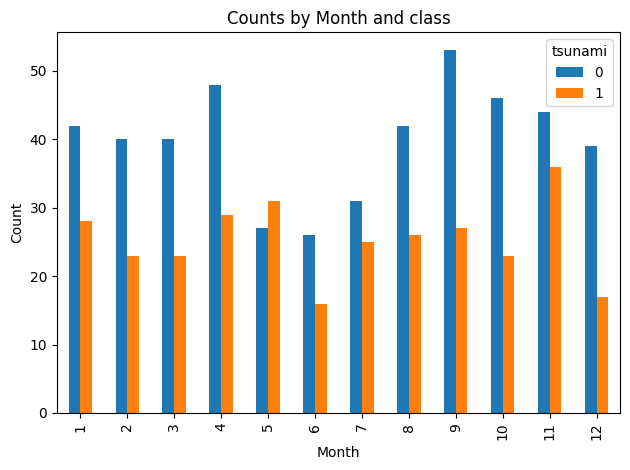

In [17]:
month_counts = df.groupby(["Month", 'tsunami']).size().unstack(fill_value=0)
plt.figure()
month_counts.plot(kind="bar")
plt.title("Counts by Month and class")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()

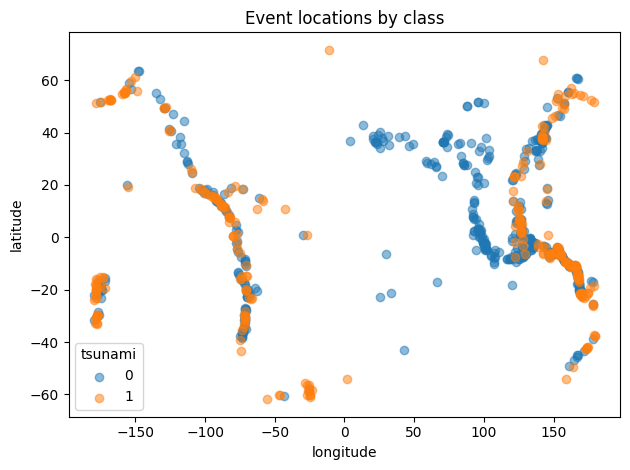

In [18]:
plt.figure()
mask0 = df['tsunami'] == 0
mask1 = df['tsunami'] == 1
plt.scatter(df.loc[mask0, 'longitude'], df.loc[mask0, 'latitude'], alpha=0.5, label="0")
plt.scatter(df.loc[mask1, 'longitude'], df.loc[mask1, 'latitude'], alpha=0.5, label="1")
plt.title("Event locations by class")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(title='tsunami')
plt.tight_layout()
plt.show()
plt.close()

Observations from EDA:

Magnitude and depth matter. Tsunami=1 skews a bit toward higher magnitude and slightly shallower depths, though there’s overlap. Good features for the first cut.

sig is strongly tied to magnitude and intensity metrics. The redundancy probe shows sig is partially predictable from other physical features. It can help predictive power, but we should decide if it’s fair at alert time or a post-hoc composite. We can train both with and without sig to be safe.

dmin (nearest station distance) has a long right tail for tsunami=1. That might reflect offshore events. gap and nst capture network geometry; useful, but noisy.

Month has mild variation; nothing dramatic. We can still allow the model to use Month or its cyclic encoding.

Locations are where you’d expect—around subduction zones. We might later add region features (bins of lat/long or clusters).

### 3. Data Preparation

The first step is creating a train/test split. But because tsunami events are rare, a simple random split could easily end up with almost no positive examples in one subset — making evaluation unreliable.

To fix this, we’ll use a stratified split, ensuring that both training and test sets maintain the same ratio of tsunami to non-tsunami events.

Cyclic month features:
Months repeat every year, so treating them as plain integers (1 to 12) ignores that continuity, December and January are actually neighbors!
To fix that, we encode months as sine and cosine pairs (month_sin, month_cos), which naturally capture the circular pattern of time.

Magnitude–Depth interaction (mag_x_depth):
Earthquakes that are both strong and shallow tend to have a higher tsunami potential. Multiplying these features gives the model a simple, interpretable way to capture that relationship.

In [19]:
# Month cyclic
df["month_sin"] = np.sin(2 * np.pi * (df["Month"].astype(float) / 12.0))
df["month_cos"] = np.cos(2 * np.pi * (df["Month"].astype(float) / 12.0))

df["mag_over_depth1"] = df["magnitude"] / (df["depth"] + 1.0)

In [20]:
# Magnitude–Depth interaction
df["mag_x_depth"] = df["magnitude"] * df["depth"]

In [ ]:
target = 'tsunami'
features = df.drop(columns=[target])

In [22]:
# Debug shapes
print("Features shape:", features.shape)
print("Target shape:", df[target].shape)
print("\nFeature columns:", features.columns.tolist())

Features shape: (782, 16)
Target shape: (782,)

Feature columns: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'month_sin', 'month_cos', 'mag_over_depth1', 'mag_x_depth']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
            features, df[target], test_size=0.2, random_state=42, stratify=df[target]
        )

### 4. Modeling

Logistic Regression:
To establish a baseline, we start with a classic — Logistic Regression. By setting the class_weight="balanced", we ensure the model accounts for the imbalance between tsunami and non-tsunami events. This helps avoid a bias towards predicting “no tsunami” all the time, which could be disastrous.

Random Forest:
Next, we step up the complexity with Random Forest, a strong non-linear model. Using class_weight="balanced_subsample", the algorithm adjusts for class imbalance in both the overall dataset and within each bootstrapped sample during training. Random Forest is better at capturing complex interactions between features, which could be important in predicting tsunamis, where relationships may not always be linear.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=200, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
}

### 5. Evaluation
When evaluating the models, we use two key tables to make sense of the results:

Model summary table: This shows the PR-AUC (Precision-Recall AUC) and ROC-AUC for both models. PR-AUC is our main focus because it gives a clearer picture of performance when dealing with imbalanced datasets. ROC-AUC can sometimes be misleading in such cases, as it treats false positives and false negatives equally.

Operating points table: Here, we report the precision, recall, and F1 scores at two important thresholds:

The threshold that maximizes F1 — this balances both precision and recall, making it a good general-purpose threshold.

The recall-target threshold — where we aim for a recall of at least 0.90, understanding that this will likely increase false alarms but reduce the risk of missing true tsunami events.

We also show two PR-curves to help reason about model performance over different thresholds

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    average_precision_score, 
    roc_auc_score,
)

collected_results = {}



for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Get probabilities on test set
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # a) Model Summary Metrics (using probability scores)
    summary_metrics = {
        'Model': name,
        'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4),
        'PR-AUC (Avg Precision)': round(average_precision_score(y_test, y_proba), 4)
    }
    

    # Store all results
    collected_results[name] = {
        'summary': summary_metrics
    }


summary_data = [res['summary'] for res in collected_results.values()]
summary_df = pd.DataFrame(summary_data).set_index('Model')
print("## 📊 Model Summary Table (Overall Performance)")
print("---")
print(summary_df.to_markdown())
print("\n")



## 📊 Model Summary Table (Overall Performance)
---
| Model               |   ROC-AUC |   PR-AUC (Avg Precision) |
|:--------------------|----------:|-------------------------:|
| Logistic Regression |    0.8873 |                   0.8092 |
| Random Forest       |    0.9688 |                   0.9037 |




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Interpretation:

ROC-AUC: This metric evaluates the overall ability of the model to distinguish between classes (tsunami vs no tsunami) across all thresholds. A higher ROC-AUC means better model performance.

Logistic Regression (0.8873): This is a solid score, indicating the model can fairly distinguish between the two classes, but it's not perfect.

Random Forest (0.9688): This is an excellent score, showing the Random Forest model is much better at distinguishing between tsunami and non-tsunami events. It’s more adept at capturing the complexities of the data.

PR-AUC (Average Precision): This is especially important for imbalanced datasets, as it focuses on the performance of the positive class (tsunami) by evaluating precision and recall across different thresholds. A higher PR-AUC means better precision and recall performance for the minority class (tsunami events).

Logistic Regression (0.8092): This score is good, but there's room for improvement. It indicates that the model does reasonably well at identifying tsunami events, but it’s not as robust as the Random Forest.

Random Forest (0.9037): This score is stronger, meaning the Random Forest model not only does a better job of distinguishing classes overall (as seen in the ROC-AUC) but also has a higher average precision when it comes to predicting tsunami events. This makes it more reliable for this task.